In [1]:
data_salvar_modelo = '220623_classificacao_clorofila_europa'

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from collections import Counter
import random
#!pip3 install pickle5
#import pickle5 as pickle
import pickle
import glob

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#!pip install imblearn
from  imblearn.under_sampling  import  CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
# https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

#!pip install xgboost==0.90
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_excel('4647_dataset_clorofila_classif_iqar.xlsx')
df_mask = data['Dominio'] == 'Europa'
data = data[df_mask]
df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()
# filtrar so para bandas e classe
df = df_filtro[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12','Classe']]
df['Classe'] = df['Classe'] - 1
df

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
17,141.0,114,80,95,78,30,29.0,23,24.0,1.0,1,2,3
37,114.0,69,77,74,83,54,66.0,51,49.0,23.0,16,4,4
49,1.0,3,1,1,1,1,1.0,1,1.0,1.0,2,6,0
51,94.0,124,164,40,23,10,3.0,5,17.0,2.0,19,6,1
54,196.0,186,234,167,192,180,195.0,185,160.0,142.0,28,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,2982.0,3540,3396,3243,3441,3486,3458.0,3730,3430.0,4218.0,3504,3418,4
4272,2982.0,3540,3396,3243,3441,3486,3458.0,3730,3430.0,4218.0,3504,3418,4
4282,3837.0,3140,3293,3243,3685,4179,4362.0,4054,4404.0,7667.0,3763,3479,2
4357,3519.0,3306,3438,3500,3906,4193,4319.0,3967,4355.0,5608.0,4225,3913,0


In [4]:
# contar classes
print('Quantidade por classe:')
print(df['Classe'].value_counts())

# filtrar por classe
df_1 = df[df['Classe']==0]
df_2 = df[df['Classe']==1]
df_3 = df[df['Classe']==2]
df_4 = df[df['Classe']==3]
df_5 = df[df['Classe']==4]
df_6 = df[df['Classe']==5]

Quantidade por classe:
4    124
3    119
0     89
2     85
5     71
1     70
Name: Classe, dtype: int64


In [5]:
#separar treino e teste
qtd_amostras_treino = 60

randomlist = random.sample(range(0, df_1.shape[0]), qtd_amostras_treino)
df_1_train = df_1.iloc[randomlist]
df_1_test = df_1.drop(df_1.index[randomlist])

randomlist = random.sample(range(0, df_2.shape[0]), qtd_amostras_treino)
df_2_train = df_2.iloc[randomlist]
df_2_test = df_2.drop(df_2.index[randomlist])

randomlist = random.sample(range(0, df_3.shape[0]), qtd_amostras_treino)
df_3_train = df_3.iloc[randomlist]
df_3_test = df_3.drop(df_3.index[randomlist])

randomlist = random.sample(range(0, df_4.shape[0]), qtd_amostras_treino)
df_4_train = df_4.iloc[randomlist]
df_4_test = df_4.drop(df_4.index[randomlist])

randomlist = random.sample(range(0, df_5.shape[0]), qtd_amostras_treino)
df_5_train = df_5.iloc[randomlist]
df_5_test = df_5.drop(df_5.index[randomlist])

randomlist = random.sample(range(0, df_6.shape[0]), qtd_amostras_treino)
df_6_train = df_6.iloc[randomlist]
df_6_test = df_6.drop(df_6.index[randomlist])

print('Classe 1 - treino:', df_1_train.shape[0], '/ teste:', df_1_test.shape[0])
print('Classe 2 - treino:', df_2_train.shape[0], '/ teste:', df_2_test.shape[0])
print('Classe 3 - treino:', df_3_train.shape[0], '/ teste:', df_3_test.shape[0])
print('Classe 4 - treino:', df_4_train.shape[0], '/ teste:', df_4_test.shape[0])
print('Classe 5 - treino:', df_5_train.shape[0], '/ teste:', df_5_test.shape[0])
print('Classe 6 - treino:', df_6_train.shape[0], '/ teste:', df_6_test.shape[0])

Classe 1 - treino: 60 / teste: 29
Classe 2 - treino: 60 / teste: 10
Classe 3 - treino: 60 / teste: 25
Classe 4 - treino: 60 / teste: 59
Classe 5 - treino: 60 / teste: 64
Classe 6 - treino: 60 / teste: 11


In [6]:
# concatenar dataframes
frames_train = [df_1_train, df_2_train, df_3_train, df_4_train, df_5_train, df_6_train]
df_train = pd.concat(frames_train)
frames_test = [df_1_test, df_2_test, df_3_test, df_4_test, df_5_test, df_6_test]
df_test = pd.concat(frames_test)
#print('Tamanho train:', df_train.shape)
#print('Tamanho test:', df_test.shape)

# separar entrada e rotulo do treino e teste
X_train = df_train.to_numpy()[:,:12]
y_train = df_train.to_numpy()[:,12].astype(int)
X_test = df_test.to_numpy()[:,:12]
y_test = df_test.to_numpy()[:,12].astype(int)

print('Tamanho train:', X_train.shape, '/ rotulos:', y_train.shape)
print('Tamanho test:', X_test.shape, '/ rotulos:', y_test.shape)

Tamanho train: (360, 12) / rotulos: (360,)
Tamanho test: (198, 12) / rotulos: (198,)


In [7]:
#padronizando dados antes do treinamento
scaler = StandardScaler()

norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.transform(X_test)

In [10]:
norm_X_train = X_train
norm_X_test = X_test

# Naive Bayes

Melhores hiperparametros do modelo: {'var_smoothing': 0.01}

Acuracia:  0.0707070707070707
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.05      0.80      0.09        10
           2       0.00      0.00      0.00        25
           3       0.50      0.02      0.03        59
           4       0.31      0.08      0.12        64
           5       0.00      0.00      0.00        11

    accuracy                           0.07       198
   macro avg       0.14      0.15      0.04       198
weighted avg       0.25      0.07      0.05       198



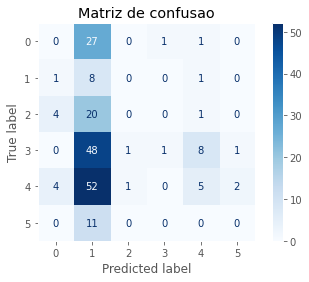

In [8]:
#treinar naive bayes

# pesquisa em grade
param_grid_nb = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

grid_nb = GridSearchCV(GaussianNB(),param_grid_nb,refit=True)
grid_nb.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_nb.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_nb, open(data_salvar_modelo+'_nb.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_nb_predictions = grid_nb.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_nb_predictions))
#print(confusion_matrix(y_teste,grid_nb_predictions))
print(classification_report(y_test, grid_nb_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_nb, norm_X_test, y_test,cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

# SVM

Melhores hiperparametros do modelo: {'C': 1000, 'gamma': 1, 'kernel': 'poly'}

Acuracia:  0.24242424242424243
              precision    recall  f1-score   support

           0       0.20      0.21      0.20        29
           1       0.00      0.00      0.00        10
           2       0.06      0.04      0.05        25
           3       0.40      0.27      0.32        59
           4       0.43      0.28      0.34        64
           5       0.24      0.64      0.35        11

    accuracy                           0.24       198
   macro avg       0.22      0.24      0.21       198
weighted avg       0.31      0.24      0.26       198



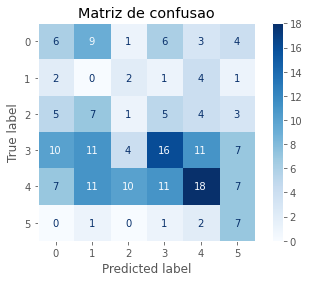

In [9]:
# treinar svm

# pesquisa em grade
param_grid_svm = {'C': [0.1,1, 10, 100,1000], 
                  'gamma': [1,0.1,0.01,0.001,0.0001], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

grid_svm = GridSearchCV(SVC(),param_grid_svm,refit=True, n_jobs=-1)
grid_svm.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_svm.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_svm, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_svm_predictions = grid_svm.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_svm_predictions))
#print(confusion_matrix(y_teste,grid_svm_predictions))
print(classification_report(y_test, grid_svm_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_svm, norm_X_test, y_test,cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

# Random Forest

Melhores hiperparametros do modelo: {'bootstrap': True, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}

Acuracia:  0.2222222222222222
              precision    recall  f1-score   support

           0       0.29      0.24      0.26        29
           1       0.06      0.20      0.09        10
           2       0.04      0.04      0.04        25
           3       0.34      0.22      0.27        59
           4       0.45      0.22      0.29        64
           5       0.16      0.64      0.25        11

    accuracy                           0.22       198
   macro avg       0.22      0.26      0.20       198
weighted avg       0.31      0.22      0.24       198



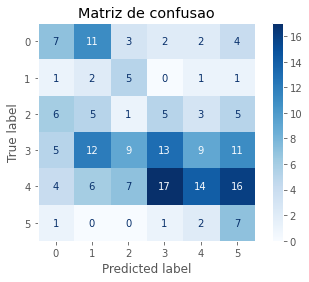

In [10]:
#treinar random forest

# pesquisa em grade
param_grid_rf = {'bootstrap': [True, False], 
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
            'max_features': ['auto', 'sqrt'], 
            'min_samples_leaf': [1, 2, 4], 
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

grid_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf,refit=True, n_jobs=-1)
grid_rf.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_rf.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_rf, open(data_salvar_modelo+'_rf.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_rf_predictions = grid_rf.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_rf_predictions))
#print(confusion_matrix(y_teste,grid_rf_predictions))
print(classification_report(y_test, grid_rf_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_rf, norm_X_test, y_test,cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()

# XGBoost

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
Melhores hiperparametros do modelo: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.001, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6}

Acuracia:  0.21212121212121213
              precision    recall  f1-score   support

           0       0.22      0.21      0.21        29
           1       0.04      0.10      0.06        10
           2       0.05      0.08      0.06        25
           3       0.35      0.25      0.29        59
           4       0.46      0.19      0.27        64
           5       0.16      0.55      0.24        11

    accuracy                           0.21       198
   macro avg       0.21      0.23      0.19       198
weighted avg       0.30      0.21      0.23       198



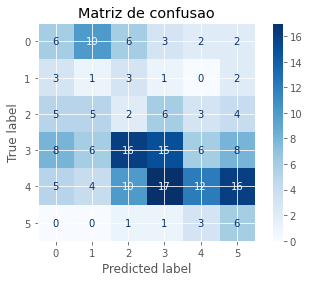

In [12]:
#treinar xgboost

# pesquisa em grade
param_grid_xgb = { 'min_child_weight': [1, 5, 10], 
                  'gamma': [0.5, 1, 1.5, 2, 5], 
                  'subsample': [0.6, 0.8, 1.0], 
                  'colsample_bytree': [0.6, 0.8, 1.0], 
                  'n_estimators': [400, 500, 600, 700], 
                  'learning_rate': [0.1, 0.01, 0.001],
                  'max_depth': [3, 4, 5] }

grid_xgb = GridSearchCV(XGBClassifier(objective='binary:logistic', 
                                      silent=True, nthread=-1, verbosity = 0, 
                                      use_label_encoder=False, n_jobs=-1),
                        param_grid_xgb, refit=True, verbose=True)

#le = LabelEncoder()
#y_train = le.fit_transform(y_train)

grid_xgb.fit(norm_X_train,y_train.astype(int))

print('Melhores hiperparametros do modelo:', grid_xgb.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_xgb, open(data_salvar_modelo+'_xgb.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_xgb_predictions = grid_xgb.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test.astype(int), grid_xgb_predictions))
#print(confusion_matrix(y_teste,grid_xgb_predictions))
print(classification_report(y_test.astype(int), grid_xgb_predictions))

# matrix de confusao
matrix = plot_confusion_matrix(grid_xgb, norm_X_test, y_test.astype(int), cmap=plt.cm.Blues)
plt.title('Matriz de confusao')
plt.show(matrix)
plt.show()